# Naiwny klasyfikator Bayesa - Kajetan Legawiec, Martyna Klin

Do klasyfikacji przy użyciu naiwnego klasyfikatora Bayesa zdecydowaliśmy się użyć zbioru danych zawierającego wiadomości __[(SMS Spam Collection)](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)__ które klasyfikować będziemy jako pożądane lub jako spam. Filtry spamu są klasycznym przykładem użycia klasyfikatora Bayesa, chcieliśmy zatem spróbować stworzyć własny. Korzystamy z bibliotek pandas i scikit-learn do stworzenia klasyfikatora oraz pyplot do wyrysowania macierzy pomyłek.
Skorzystaliśmy z Jupytera, ponieważ był dla nas bardziej intuicyjny przy analizie danych w Pythonie.

In [12]:
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot

## Czyszczenie i przygotowanie danych

Pierwsze, co robimy, to załadowanie zbioru danych oraz podzielenie danych na testowe i treningowe.

In [13]:
data = pd.read_csv('sms/SMSSpamCollection', sep='\t', header=None, names=['label', 'sms'])

In [14]:
y = data.iloc[:,0]
X = data.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

Patrzymy na proporcje "spam" i "ham", upewniając się, że są wystarczająco podobne w zbiorze danych treningowych i testowych.

In [15]:
y_train.value_counts(normalize=True)

label
ham     0.865757
spam    0.134243
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

label
ham     0.866475
spam    0.133525
Name: proportion, dtype: float64

Przygotowujemy część tekstową poprzez konwersję na małe litery, usunięcie interpunkcji i podzielenie łańcucha znaków na listę słów. Tworzymy w dataframe nową kolumnę, która zawiera te listy.

In [17]:
def text_cleaning(text):
    text = text.translate(str.maketrans('', '',string.punctuation))
    text = text.lower()

    return list(text.split())

In [18]:
X_train['words'] = X_train['sms'].apply(text_cleaning)
X_train.head()

,sms,words
4281,WINNER!! As a valued network customer you have...,"[winner, as, a, valued, network, customer, you..."
585,So how's scotland. Hope you are not over showi...,"[so, hows, scotland, hope, you, are, not, over..."
4545,when you and derek done with class?,"[when, you, and, derek, done, with, class]"
3034,"Aight, lemme know what's up","[aight, lemme, know, whats, up]"
2758,Yo we are watching a movie on netflix,"[yo, we, are, watching, a, movie, on, netflix]"


## Ustalanie prawdopodobieństw

Tworzymy słownik, który zawiera ilość wiadomości z każdej kategorii wewnątrz zbioru treningowego.

In [19]:
class_count_dict = {
    'ham': int(y_train.value_counts().iloc[0]),
    'spam': int(y_train.value_counts().iloc[1])
}
class_count_dict

{'ham': 3618, 'spam': 561}

Dla każdego słowa występującego w naszych danych treningowych, zliczamy ilość ich wystąpień w wiadomościach pożądanych i niepożądanych, upewniając się, że nie nadpisujemy danych w słowniku przy kolejnym wystąpieniu słowa. Zliczamy także sumę wszystkich słów dla obu klas wiadomości.

In [20]:
def count_frequencies(data):
    word_freq_dict = {}
    words_per_class_dict = {
        'ham': 0,
        'spam': 0
    }
    
    for index, row in data.iterrows():
        label = y.iloc[index]
        for word in row['words']:
            if word not in word_freq_dict.keys():
                word_freq_dict[word] = {"spam": 0, "ham": 0}
            
            if label == 'spam':
                word_freq_dict[word]["spam"] += 1
                words_per_class_dict['spam'] += 1
            else:
                word_freq_dict[word]["ham"] += 1
                words_per_class_dict['ham'] += 1
    return (word_freq_dict, words_per_class_dict)

In [21]:
word_freq_dict, words_per_class_dict = count_frequencies(X_train)

In [22]:
word_freq_dict['and'] # testowe słowo dla sprawdzenia słownika

{'spam': 95, 'ham': 637}

Zliczamy unikatowe słowa we wszystkich wiadomościach za pomocą stworzonego słownika.

In [23]:
vocab_size = len(word_freq_dict)
vocab_size

8249

Liczymy prawdopodobieństwa wystąpienia każdego słowa w naszym słowniku pod warunkiem, że należy ono do wiadomości pożadanej lub niepożadanej. Stosujemy wygładzanie Laplace'a, aby uniknąć problemu zerowych prawdopodobieństw poprzez dodanie stałej (tutaj domyślnie alpha = 1) do liczebności każdej cechy, co sprawia, że żadna obserwacja nie ma prawdopodobieństwa zerowego. Co byłoby złe, jak potem wyliczamy iloraz.

In [24]:
def calculate_word_probabilities(word_freq_dict, words_per_class_dict, vocab_size, alpha = 1):
    word_prob_dict = {}
    
    for word, freq in word_freq_dict.items():
        word_prob_dict[word] = {}
        
        word_prob_dict[word]['spam'] = (freq['spam'] + alpha) / (words_per_class_dict['spam'] + alpha*vocab_size)
        
        word_prob_dict[word]['ham'] = (freq['ham'] + alpha) / (words_per_class_dict['ham'] + alpha*vocab_size)
    
    return word_prob_dict

In [25]:
word_prob_dict = calculate_word_probabilities(word_freq_dict, words_per_class_dict, vocab_size)
word_prob_dict['and'] # testowe słowo dla sprawdzenia słownika

{'spam': 0.004459308807134894, 'ham': 0.010705416470904087}

## Klasyfikacja

Przygotowujemy czysty tekst (dzielimy go na listę słów tak jak zbiór treningowy). W tej funkcji jest zawarty naiwny klasyfikator Bayesa - mnożymy prawdopodobieństwo, że wiadomość jest pożądana lub niepożadana (na podstawie proporcji wyliczonych wcześniej na bazie danych treningowych) przez prawdopodobieństwa każdego następnego słowa w wiadomości. Robimy to osobno dla prawdopodobieństwa wiadomości pożądanych i niepożądanych - w zależności od tego, który wynik jest wyższy, tak klasyfikujemy wiadomość.

In [26]:
def test_message(text, word_prob_dict):
    words = text_cleaning(text)

    message_count = class_count_dict["spam"] + class_count_dict["ham"]

    spam_prob = class_count_dict["spam"] / message_count
    ham_prob = class_count_dict["ham"] / message_count

    for word in words:
        if word in word_prob_dict.keys():
            spam_prob *= word_prob_dict[word]['spam']
            ham_prob *= word_prob_dict[word]['ham']

    if spam_prob > ham_prob:
        return 'spam'
    else:
        return 'ham'

Wywołujemy funkcję lambdą na każdy rekord danych testowych.

In [27]:
f = lambda x : test_message( x , word_prob_dict)
y_pred = X_test['sms'].apply(f)
y_pred

3245    ham
944     ham
1044    ham
2484    ham
812     ham
       ... 
668     ham
218     ham
5536    ham
1657    ham
3875    ham
Name: sms, Length: 1393, dtype: object

Przygotowujemy macierz pomyłek i raport klasyfikacji, który pokaże nam jak dobry jest model w klasyfikacji.

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1207
        spam       0.99      0.91      0.95       186

    accuracy                           0.99      1393
   macro avg       0.99      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393



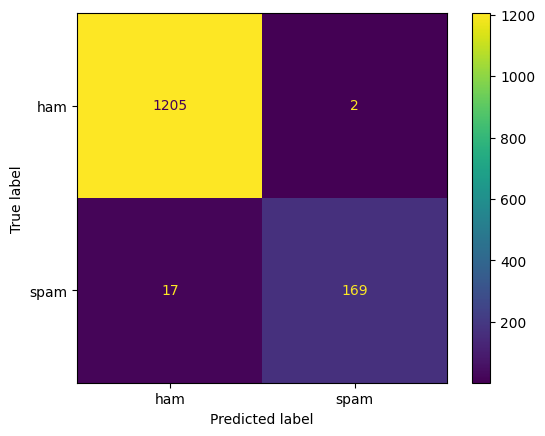

In [28]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['ham', 'spam'])
disp.plot()